# DETECCION DE PEATONES CON HOG Y SVM


# Se cargan las bibliotecas necesarias

In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

In [17]:
import glob

#vehicle = glob.glob("data_svm/vehicles/**/*.png")
#no_vehicle = glob.glob("data_svm/non-vehicles/**/*.png")

#peaton = glob.glob(r"D:\Materias MNA\Vehículos autónomos\Navegaci-n-Aut-noma_Equipo-15-main\Actividad 3.1_Deteccion_de_Peatones\peatones\si_peatones\**\*.*")
#peaton = glob.glob(r"C:/Users/der_e\Navegaci-n-Aut-noma_Equipo-15-main\Actividad 3.1_Deteccion_de_Peatones\peatones\si_peatones\**\*.*")
peaton = glob.glob(r"peatones/si_peatones/**/*.*")

#no_peaton = glob.glob("peatones/no_peatones/*.jpg")
no_peaton = glob.glob("C:/Users/der_e/Navegación Autónoma_Scripts/03_Machine_Learning/data_svm/non-vehicles/**/*.png")

In [18]:
#len(vehicle)
len(peaton)

1339

In [19]:
#len(no_vehicle)
len(no_peaton)

3900

# Se muestra una imagen con vehículo

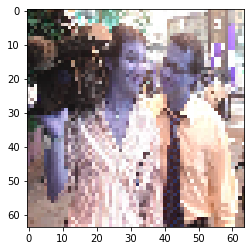

In [33]:
img = cv2.imread(peaton[17])
img_color_peaton = cv2.resize(img, (64,64)) #Estandarizamos el tamaño de todas las imágenes para poder procesarlas.
plt.imshow(img_color_peaton)

In [26]:
img_non = cv2.imread(no_peaton[1])
#img_non2 = cv2.resize(img_non, (64, 64))
#plt.imshow(img_non)

# Para fines de demostración se calcula el HOG de la imagen

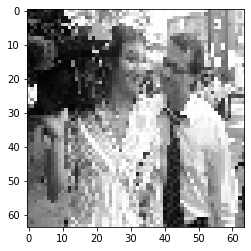

In [34]:
img_gray_peaton = cv2.cvtColor(img_color_peaton,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray_peaton,cmap="gray")

In [35]:
features,hog_img = hog(img_gray_peaton,
                       orientations = 10,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [36]:
features.shape

(360,)

In [37]:
hog_img.shape

(64, 64)

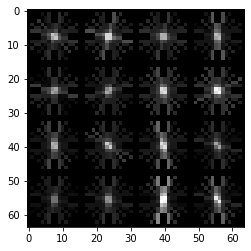

In [38]:
plt.imshow(hog_img,cmap = 'gray')

# Se extraen las features del HOG para ambos tipos de datos

In [39]:
peaton_hog_accum = []

for i in peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_res = cv2.resize(img_gray, (64,64))
    peaton_hog_feature, peaton_hog_img = hog(img_res,
                                               orientations = 10,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    peaton_hog_accum.append(peaton_hog_feature)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
X_peaton = np.vstack(peaton_hog_accum).astype(np.float64)
y_peaton = np.ones(len(X_peaton))

In [ ]:
X_peaton.shape

In [ ]:
y_peaton.shape

In [ ]:
no_peaton_hog_accum = []

for i in no_peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    no_peaton_hog_feature, no_peaton_hog_img = hog(img_gray,
                                               orientations = 10,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    no_peaton_hog_accum.append(no_peaton_hog_feature)

In [ ]:
X_no_peaton = np.vstack(no_peaton_hog_accum).astype(np.float64)
y_no_peaton = np.zeros(len(X_no_peaton))

In [ ]:
X_no_peaton.shape

In [ ]:
y_no_peaton.shape

# Se combinan ambos tipos de datos para alimentar el SVM

In [ ]:
X = np.vstack((X_peaton,X_no_peaton))
X.shape

In [ ]:
y = np.hstack((y_peaton,y_no_peaton))
y.shape

# Se generan los datos de entrenamiento y de prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

# Se importa el Clasificador y se entrena

In [ ]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

In [ ]:
y_predict = svc_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [ ]:
print(classification_report(y_test,y_predict))

# GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [ ]:
print(classification_report(y_test,grid_predictions))